# 1. Сбор данных и их предобработка

In [ ]:
!pip install topicnet
import artm
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 KB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.4 MB/s eta 0:00:00
  Created wheel for topicnet: filename=topicnet-0.8.0-py3-none-any.whl size=134578 sha256=382c5f6ad311788c20f6ea707266449552f146104ca9452fe0737c700927b3b1
  Stored in directory: /root/.cache/pip/wheels/5d/98/ac/3329dd1fb9caffaa5660edbfea060a56866f90ac9666ccc9ca
  Created wheel for strictyaml: filename=strictyaml-1.6.2-py3-none-any.whl size=123941 sha256=e9b3fccfbcdd37a47a31b9e2de0a69a69602c7faa3282a527fbf9623fd780974
  Stored in directory: /root/.cache/pip/wheels/e9/0b/fc/5beda6bad2ff803e820e15

In [ ]:
!pip install pymorphy3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=4b666b7a971b59174206bc02731ef2ed2b334086291bb9d792da8ac40476b790
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import itertools 

In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import preprocessing
import requests
import json
from urllib.request import urlopen
from typing import List
import re
import numpy as np
import concurrent.futures
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pymorphy3
from time import perf_counter
import pandas as pd
import copy

##1.1 Получаем ID вакансий

In [ ]:
def get_vacancies_ids_name(texts: List[str], pages: int = 20) -> List[int]: #пробегаемся по 20 страницам с результатами работы api hh ru
    vacancies_ids = []

    for text in texts:
        for i in range(pages):
            response = requests.get(f'https://api.hh.ru/vacancies?text={text}&page={i}&per_page=100').content
            data_json = json.loads(response)
            for item in data_json['items']:
                id = int(item['id'])
                if id not in vacancies_ids:
                    vacancies_ids.append(id)
    return vacancies_ids

In [ ]:
vacancies_ids = get_vacancies_ids_name(["кибербезопасность", "кибер безопасность", "кибербез", "информационная безопасность"]) #поиск производится по ключевым словам в названии вакансии

In [ ]:
print(f"Получено {len(vacancies_ids)} вакансий")

Получено 2692 вакансий


##1.2 Скачиваем вакансии по соответствующим ID

In [ ]:
def download_vacancy_json(id): #функция для скачивания вакансии по её ID
  url = f"https://api.hh.ru/vacancies/{id}"
  response = urlopen(url)  
  data_json = json.loads(response.read())  
  return data_json

##1.3 Обработка вакансий и асинхронность

In [ ]:
def remove_garbage(raw_text): #очистка текста от ссылок, двойных пробелов, чисел, некоторых спецсимволов
  text_copy = raw_text.lower()
  text_copy = re.sub(r"<([\s\S]+?)>", ' ', text_copy)
  text_copy = re.sub(r"&([\s\S]+?);", ' ', text_copy)
  text_copy = re.sub(r"(www[\S]+)|(http\S+)", ' ', text_copy)
  text_copy = re.sub(r"([0-9])|([_])", ' ', text_copy)
  text_copy = re.sub(r"\s+", ' ', text_copy)
  return text_copy

In [ ]:
def tokenize(raw_text): #векторизация средствами библиотеки
  tokens = word_tokenize(raw_text.lower())  
  return tokens

In [ ]:
from nltk.corpus import stopwords #удаляем стопслова. Было принято решение дополнить список стопслов на русском языке спецсимволами и зависимыми стоп словами
def remove_stop_words(raw_text):
  filtered_words = []
  punctuation_symbols = set([',', '?', '!', '—', ':', '-', '«', '»', ';', '(', ')', '–', '\\', '/', '.'])
  stop_words_else = set(['тк', 'рф', 'опыт', 'искать', 'понимание', 'знание', 'год', 'зп', 'проект', 'наш', 'клиент', 'руб', 'рубль', 'услуга',
                         'зарплата', 'российский', 'фирма', 'месяц', 'год', 'день', 'время', 'час', 'свой', 'офис', 'скидка', 'студент', 'опыт'
                         'страхование', 'также', 'так', 'команда', 'компания', 'жизнь', 'договор', 'работа', 'понимание', 'знание'])
  stop_words = set(stopwords.words('russian'))
  stop_words = stop_words.union(stop_words_else)
  stop_words_en = set(stopwords.words('english'))
  for word in raw_text:
    if word not in stop_words and word not in stop_words_en and word not in punctuation_symbols:
      filtered_words.append(word)
  return filtered_words

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
def to_base_form(raw_text): #лемматизация токенов
  tokens = []
  lemmatizer = pymorphy3.MorphAnalyzer()
  for word in raw_text:
    token_normal_form = lemmatizer.parse(word)[0]
    tokens.append(token_normal_form.normal_form)
  return tokens

In [ ]:
def get_prepared_vacancy_from_hh(vacancy_id): #итоговая функция обработки вакансии
  vacancy_json = download_vacancy_json(vacancy_id)
  vacancy_description = vacancy_json['description']
  stime = perf_counter()
  remove_garbage_vacancy = remove_garbage(vacancy_description)
  stime = perf_counter()
  tokenize_vacancy = tokenize(remove_garbage_vacancy)
  base_form_vacancy = to_base_form(tokenize_vacancy)
  prepared_vacancy_description = remove_stop_words(base_form_vacancy)
  return ",".join(prepared_vacancy_description)

In [ ]:
def get_prepared_all_vacancies_from_hh(vacancy_ids, dataframe, n): #функция, обрабатывающая пачку вакансий
  start_time = perf_counter() 
  for id in vacancy_ids:
    resDesc = get_prepared_vacancy_from_hh(id)
    new_row = {"vacancy_id": id, "vacancy_description" : resDesc}
    dataframe = dataframe.append(new_row, ignore_index=True)    
  return dataframe

In [ ]:
data = {"vacancy_id":object, "vacancy_description" : []}
dataframe = pd.DataFrame(data = data)

In [ ]:
number_workers = 15 #подключаем асинхронность и многопоточность
with ThreadPoolExecutor(max_workers = number_workers) as executor:
    futures = []
    prev_n = 0
    step_size = int(np.ceil(len(vacancies_ids)/number_workers))
    for n in range(number_workers):
        futures.append(executor.submit(get_prepared_all_vacancies_from_hh, vacancies_ids[prev_n:prev_n + step_size], dataframe, n))
        prev_n += step_size
    for future in concurrent.futures.as_completed(futures):
        dataframe = dataframe.append(future.result(), ignore_index = True)
end_time = perf_counter()   

In [ ]:
dataframe['vacancy_description']

0       требование,образование,средний,специальный,выс...
1       внимание,аккредитовать,минцифра,swordfish,secu...
2       активбизнесконсалта,основать,сбер,абк,являться...
3       период,испытательный,срок,кандидат,потребовать...
4       обязанность,контроль,проведение,согласно,-фз,б...
                              ...                        
2687    просто,вакансия,уникальный,возможность,который...
2688    просто,вакансия,уникальный,возможность,который...
2689    r-vision,разработчик,система,кибербезопасность...
2690    tprotect,специализировать,интегратор,область,к...
2691    пaо,рocтелeкий,-росcийский,пpовайдер,цифровыx,...
Name: vacancy_description, Length: 2692, dtype: object

#2. Тематическое моделирование средствами bigartm

In [ ]:
def artm_metrics(model_plsa): #функция по оценке метрик качества обученной модели
    print(f'Kernel contrast: {model_plsa.score_tracker["TopicKernelScore"].last_average_contrast}') #контрастность ядра темы - то, насколько ярко выделенные темы отличаются друг от друга
    print(f'Kernel purity: {model_plsa.score_tracker["TopicKernelScore"].last_average_purity}') #чИстота ядра темы - то, насколько подобранные термины хорошо описывают тему 
    print(f'Perplexity: {model_plsa.score_tracker["PerplexityScore"].last_value}') #степень удивления модели при встрече незнакомого слова
    plt.plot(range(model_plsa.num_phi_updates),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--',)
    plt.xlabel('Итерации обучения')
    plt.ylabel('Перплексия')
    plt.grid(True)
    plt.show()
 

##2.1 Векторизация

In [ ]:
vacancies = copy.deepcopy(dataframe['vacancy_description'])

In [ ]:
for i in range(len(dataframe)):
  vacancies[i] = re.sub(r"([,]{2,}?)|([:\/[]])", "", str(vacancies[i])) #доочистка от спецсимволов

In [ ]:
vacancy_desc = vacancies.drop_duplicates().values #сброс одинаковых вакансий

In [ ]:
dataframe

vacancy_id                                vacancy_description
0      74159121  требование,образование,средний,специальный,выс...
1      69625595  внимание,аккредитовать,минцифра,swordfish,secu...
2      71634325  активбизнесконсалта,основать,сбер,абк,являться...
3      75635489  период,испытательный,срок,кандидат,потребовать...
4      73475162  обязанность,контроль,проведение,согласно,-фз,б...
...         ...                                                ...
2687   75929966  просто,вакансия,уникальный,возможность,который...
2688   75929269  просто,вакансия,уникальный,возможность,который...
2689   75846656  r-vision,разработчик,система,кибербезопасность...
2690   73848206  tprotect,специализировать,интегратор,область,к...
2691   75930019  пaо,рocтелeкий,-росcийский,пpовайдер,цифровыx,...

[2692 rows x 2 columns]

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(vacancy_desc)

##2.2 BigArtm модель

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',
                                        n_wd=X.transpose(),
                                        vocabulary=vectorizer.get_feature_names_out(),
                                        target_folder='batch_vectorize5')

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batch_vectorize5')

In [ ]:
def learn_model(number_topics, dictionary, SpThReg, SpPhiReg):
  theme_model_artm = artm.ARTM(num_topics = number_topics, dictionary=dictionary, cache_theta= True, scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)])
  theme_model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10)) #метрика оценки модели – топ 10 (num_tokens) слов  по каждой тематике
  theme_model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3)) 
  theme_model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
  theme_model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))
  theme_model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer'))
  theme_model_artm.regularizers['sparse_phi_regularizer'].tau = SpThReg #регуляризатор разреженности матрицы Фи
  theme_model_artm.regularizers['sparse_theta_regularizer'].tau = SpPhiReg #регуляризатор разреженности матрицы Тета
  theme_model_artm.regularizers['decorrelator_phi_regularizer'].tau = 1e+5  #регуляризатор декорелляции, позволяющий уменьшить корреляцию между темами 
  theme_model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
  return theme_model_artm

SmoothSparsePhiRegularizer = -0.830029058918291
SmoothSparseThetaRegularizer = -0.5373355491531855
Perplexity: 1042.6275634765625
Kernel contrast: 0.8321714401245117
Kernel purity: 0.7180266380310059
Perplexity: 1042.6275634765625


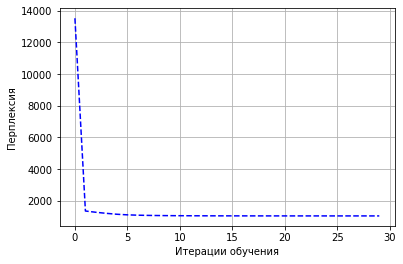

In [ ]:
i = 0
while True:
  SpThReg = np.random.uniform(-1, 1)
  SpPhiReg = np.random.uniform(-1, 1)
  theme_model_artm = learn_model(6, dictionary, SpThReg, SpPhiReg)
  if (theme_model_artm.score_tracker["PerplexityScore"].last_value <= 1100) or i == 30:
    print(f"SmoothSparsePhiRegularizer = {SpThReg}")
    print(f"SmoothSparseThetaRegularizer = {SpPhiReg}")
    print(f'Perplexity: {theme_model_artm.score_tracker["PerplexityScore"].last_value}')
    artm_metrics(theme_model_artm)
    break
  print(f'Perplexity: {theme_model_artm.score_tracker["PerplexityScore"].last_value}')
  print(f'Kernel contrast: {theme_model_artm.score_tracker["TopicKernelScore"].last_average_contrast} ')
  print(f'Kernel purity: {theme_model_artm.score_tracker["TopicKernelScore"].last_average_purity} ')
  print(f'{i} iterations')
  i += 1


In [ ]:
for theme in theme_model_artm.topic_names:
  print(theme + ": ")
  print(theme_model_artm.score_tracker['TopTokensScore'].last_tokens[theme])

topic_0: 
['разработка', 'продукт', 'сервис', 'решение', 'приложение', 'кибербезопасность', 'тестирование', 'архитектура', 'данные', 'анализ']
topic_1: 
['инцидент', 'корпоративный', 'реагирование', 'сотрудник', 'который', 'программа', 'атака', 'обучение', 'возможность', 'льготный']
topic_2: 
['администрирование', 'сетевой', 'оборудование', 'настройка', 'система', 'сеть', 'windows', 'linux', 'поддержка', 'обеспечение']
topic_3: 
['безопасность', 'информационный', 'иб', 'система', 'область', 'защита', 'разработка', 'технический', 'участие', 'требование']
topic_4: 
['информация', 'защита', 'информационный', 'безопасность', 'требование', 'средство', 'обеспечение', 'технический', 'система', 'контроль']
topic_5: 
['задача', 'возможность', 'сотрудник', 'продукт', 'решение', 'который', 'корпоративный', 'обучение', 'заказчик', 'работать']


In [ ]:
theme_model_artm_topic_res = {}

for theme in theme_model_artm.topic_names:
  topic_w = np.round(theme_model_artm.get_theta().loc[f'{theme}'].mean(), 4)
  print(f"{theme} :", topic_w)
  theme_model_artm_topic_res[theme]=dict(zip(theme_model_artm.score_tracker['TopTokensScore'].last_tokens[theme],
                            theme_model_artm.score_tracker['TopTokensScore'].last_weights[theme]))
  for (term, w) in zip(theme_model_artm.score_tracker['TopTokensScore'].last_tokens[theme], theme_model_artm.score_tracker['TopTokensScore'].last_weights[theme]):
      print(f"{term} – {np.round(w,5)}")


topic_0 : 0.0934
разработка – 0.01985
продукт – 0.01616
сервис – 0.01173
решение – 0.01131
приложение – 0.01077
кибербезопасность – 0.01028
тестирование – 0.00846
архитектура – 0.00805
данные – 0.00778
анализ – 0.00718
topic_1 : 0.0777
инцидент – 0.01653
корпоративный – 0.01028
реагирование – 0.00846
сотрудник – 0.00805
который – 0.00758
программа – 0.00673
атака – 0.00664
обучение – 0.00644
возможность – 0.00591
льготный – 0.00585
topic_2 : 0.1262
администрирование – 0.02805
сетевой – 0.02377
оборудование – 0.0219
настройка – 0.02008
система – 0.01953
сеть – 0.01871
windows – 0.01387
linux – 0.01176
поддержка – 0.01072
обеспечение – 0.01011
topic_3 : 0.2634
безопасность – 0.03405
информационный – 0.03351
иб – 0.03113
система – 0.02819
область – 0.01405
защита – 0.01402
разработка – 0.01392
технический – 0.0126
участие – 0.01209
требование – 0.01169
topic_4 : 0.2828
информация – 0.03948
защита – 0.03768
информационный – 0.03251
безопасность – 0.03042
требование – 0.01854
средство – 0.0

In [ ]:
with open('topics_model_result.json', 'w') as f:
  f.write(json.dumps(theme_model_artm_topic_res, indent=4, ensure_ascii=False))

##2.3 Визуализация тематической модели

In [ ]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

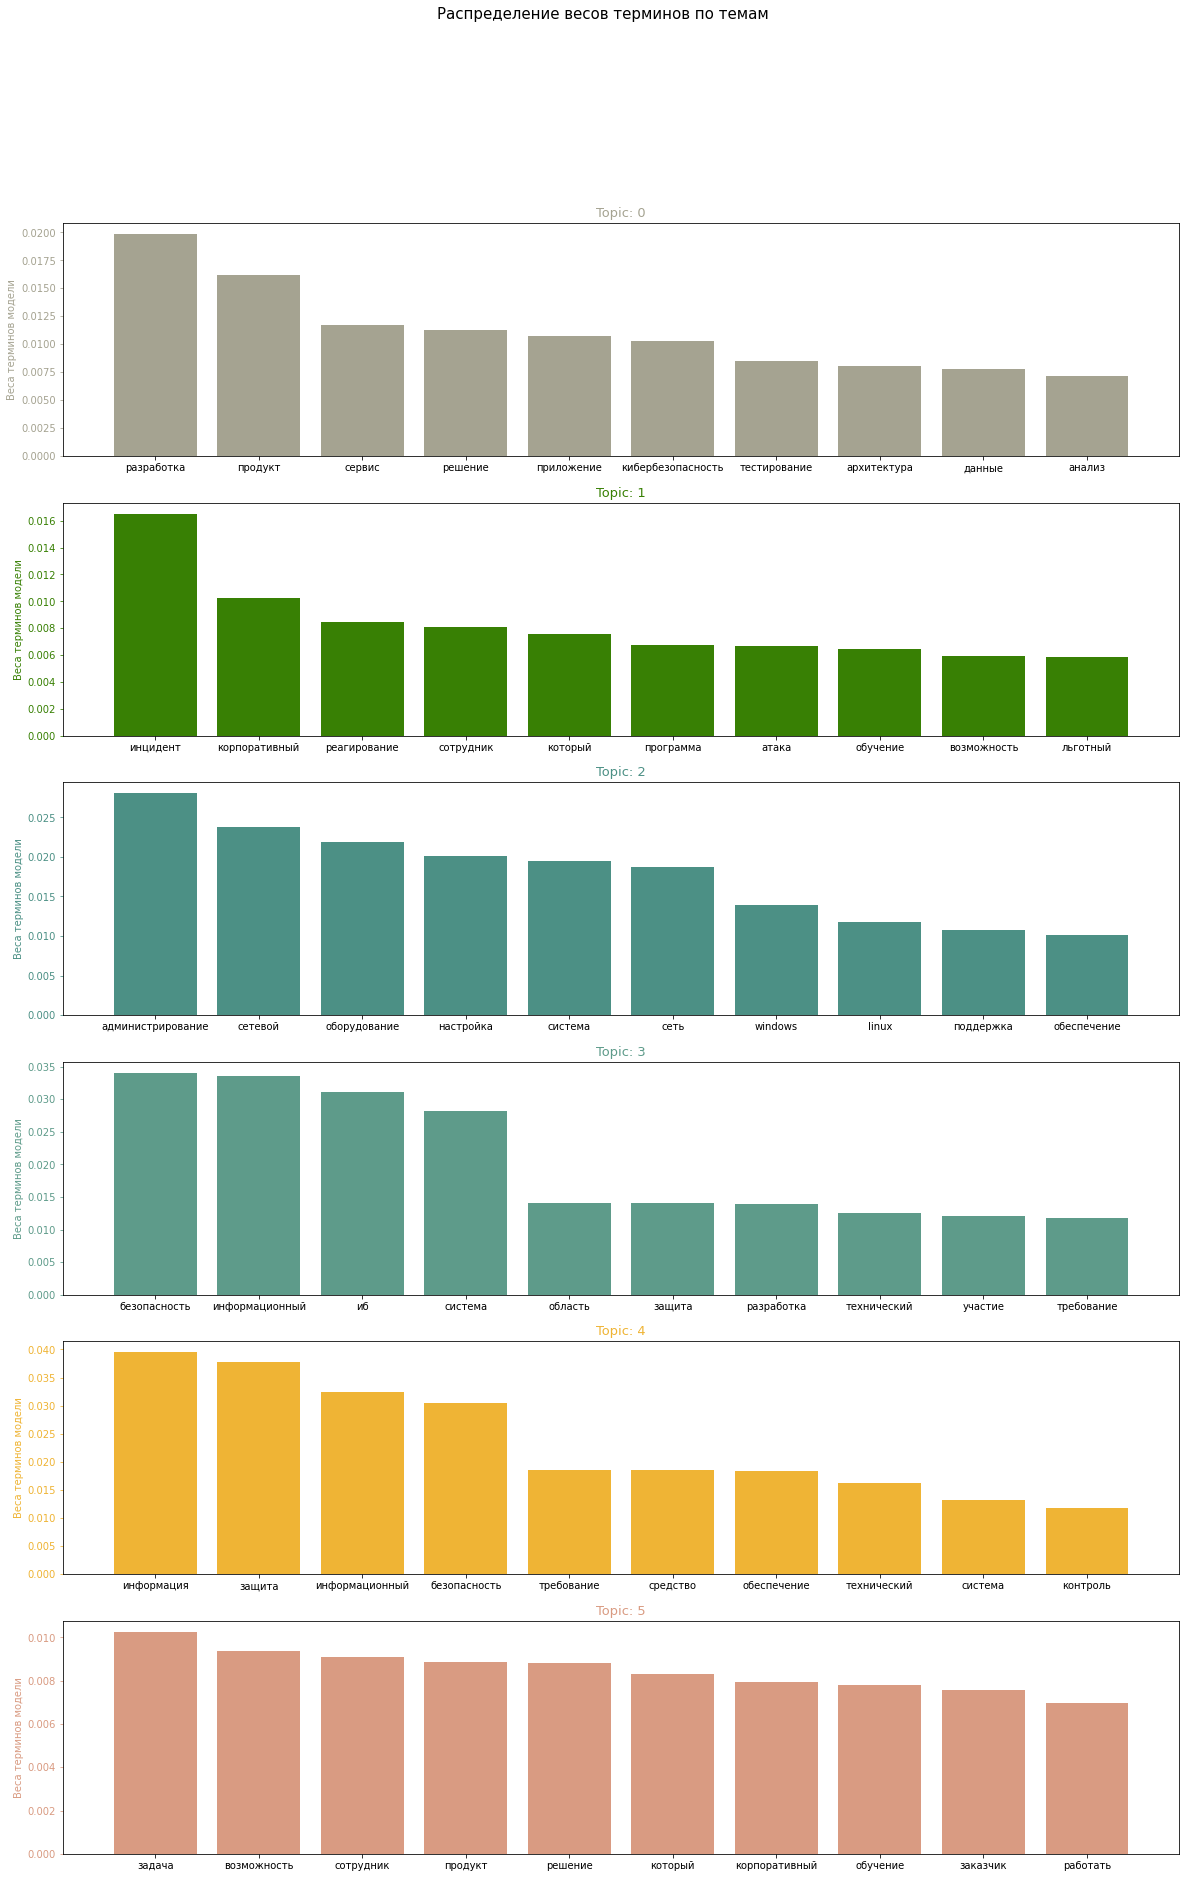

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for color in colors_list[11:17]]
fig, axes = plt.subplots(6, 1, figsize=(20,30))
for i, ax in enumerate(axes.flatten()):
    topic_name = theme_model_artm.topic_names[i]
    words = list(theme_model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])
    weights = theme_model_artm.score_tracker['TopTokensScore'].last_weights[topic_name]
    ax.bar(words, weights, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    ax.set_ylabel('Веса терминов модели', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=13, color=cols[i]))
fig.suptitle('Распределение весов терминов по темам', fontsize=15)
plt.show()

In [ ]:
def str_corpus(corpus): # Получаем из списка слов текстовую строку
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_corpus(data): # Получаем список всех слов в corpus
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

def get_wordCloud(corpus): # Получаем облако слов
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

In [ ]:
corpus = get_corpus(dataframe['vacancy_description'])
procWordCloud = get_wordCloud(corpus)

<ipython-input-38-b70d9a3215f6>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


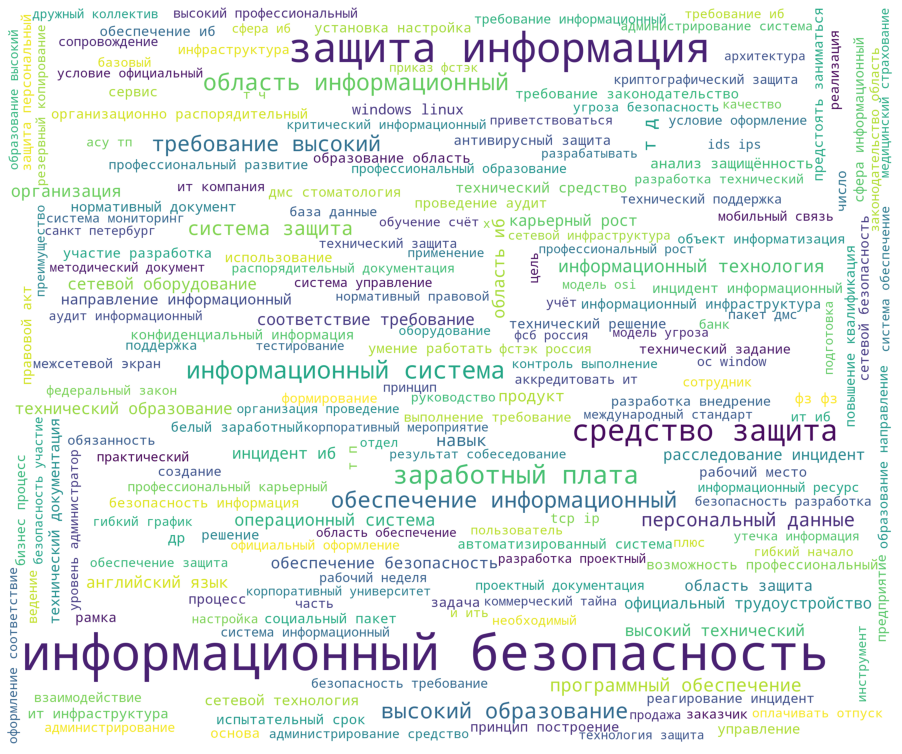

In [ ]:
fig = plt.figure(figsize=(35, 30))
plt.subplot(1, 2, 2)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 2)

#3. Формирование тематического профиля

##3.1 Кластеризация методом K-means

In [ ]:
text = [' '.join(theme_model_artm.score_tracker['TopTokensScore'].last_tokens[topic]) for topic in theme_model_artm.topic_names]
X = vectorizer.transform(text)
model = KMeans(n_clusters=3)
model.fit(preprocessing.normalize(X))
predicted_label = model.predict(preprocessing.normalize(X))
print(predicted_label)

[2 0 1 1 1 0]


##3.2 Построение тематического профиля

In [ ]:
classes_enc = {
    0: 'Уметь',
    1: 'Знать',
    2: 'Владеть',
}
results_theme_profile = {
    'Знать': {},
    'Уметь': {},
    'Владеть': {},
}
for class_idx, topic_name in list(zip(predicted_label, theme_model_artm.topic_names)):
    for token_name, token_weight in zip(theme_model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name], theme_model_artm.score_tracker['TopTokensScore'].last_weights[topic_name]):
      if token_name in results_theme_profile[classes_enc[class_idx]].keys():
        results_theme_profile[classes_enc[class_idx]][token_name] += token_weight
      else:
        results_theme_profile[classes_enc[class_idx]][token_name] = token_weight

for topic_name in results_theme_profile:
  norm = np.sqrt(np.sum(np.power(list(results_theme_profile[topic_name].values()), 2)))

  for token, weigth in results_theme_profile[topic_name].items():
    results_theme_profile[topic_name][token] = weigth / norm

In [ ]:
with open('theme_profile_result2.json', 'w') as f:
  f.write(json.dumps(results_theme_profile, indent=4, ensure_ascii=False))

In [ ]:
results_theme_profile

{'Знать': {'администрирование': 0.18093318500213967,
  'сетевой': 0.15332779031660732,
  'оборудование': 0.14125440603325085,
  'настройка': 0.12954082566708036,
  'система': 0.39269223986067303,
  'сеть': 0.12069118498678887,
  'windows': 0.08948950550844709,
  'linux': 0.07585079454172329,
  'поддержка': 0.06912938988596522,
  'обеспечение': 0.183932818697798,
  'безопасность': 0.41589458773235766,
  'информационный': 0.4258794798864515,
  'иб': 0.2008250917032979,
  'область': 0.09062608478283217,
  'защита': 0.33353685536565264,
  'разработка': 0.08982594974841271,
  'технический': 0.18622185678023423,
  'участие': 0.07798410745083778,
  'требование': 0.19503195183412023,
  'информация': 0.2547051725482627,
  'средство': 0.11957749074597693,
  'контроль': 0.07551601455859666},
 'Уметь': {'инцидент': 0.3563506547132361,
  'корпоративный': 0.3931693324612707,
  'реагирование': 0.18241736812706116,
  'сотрудник': 0.37000471466113405,
  'который': 0.3429404022096093,
  'программа': 0.1

##3.2 Визуализация тематического профиля

In [ ]:
def draw_graph(theme_name, theme_terms, theme_weights, type_graph):
  fig, graph = plt.subplots(1, 1, figsize=(12, 12))
  if type_graph == "clouds":
    corpus = get_corpus([theme_terms[i] for i in range(len(theme_terms)) for _ in range(theme_terms_count[i])])
    corpus = list(set(corpus))
    terms_cloud = get_wordCloud(corpus)
    graph.imshow(terms_cloud)
    graph.set_title(theme_name, fontdict=dict(size=16, color="black"))
    plt.show()
  elif type_graph == "pie":
    graph.pie(np.array(theme_weights) * 100, labels = theme_terms, colors = colors_list, autopct='%1.2f%%')
    graph.set_title(theme_name, fontdict=dict(size=16, color="black"))

In [ ]:
keys_descriptors = list(results_theme_profile.keys())

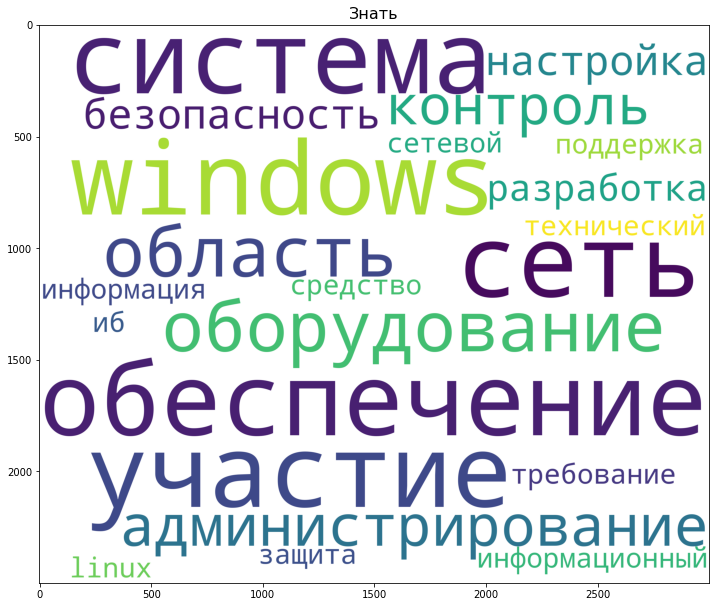

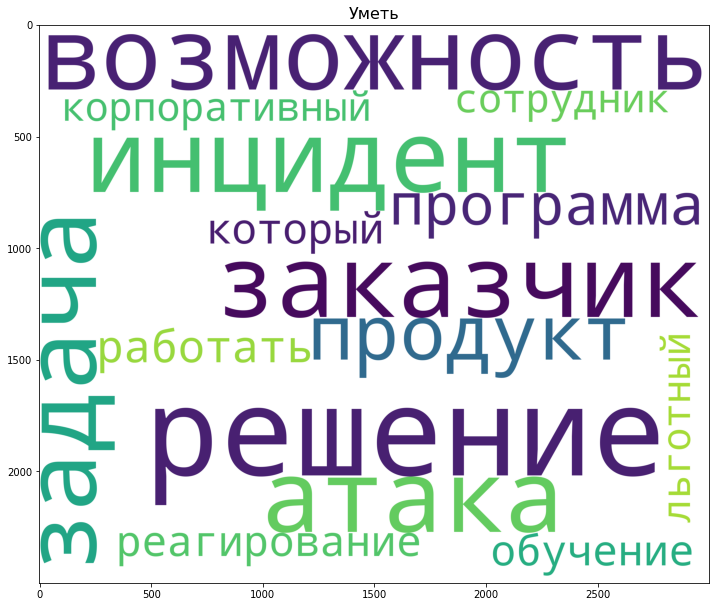

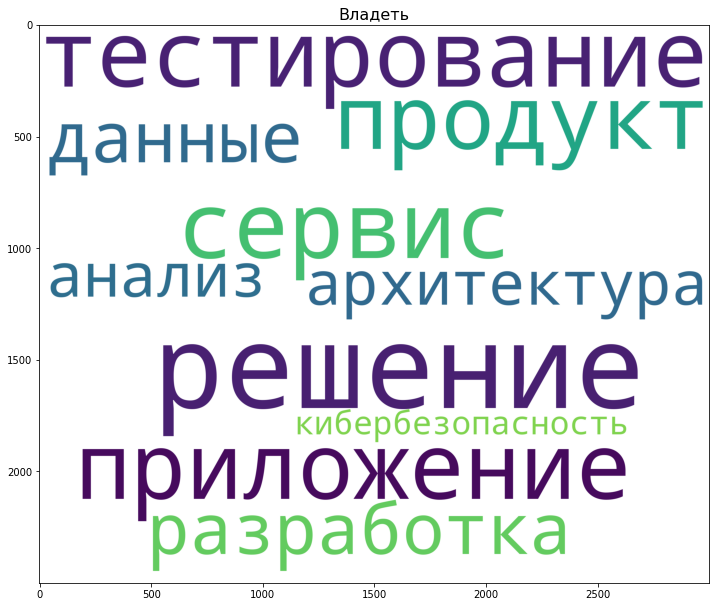

In [ ]:
for i in range(len(keys_descriptors)):
    theme_name = keys_descriptors[i]
    theme_terms = list(results_theme_profile[theme_name].keys())
    theme_weights = list(results_theme_profile[theme_name].values())
    theme_terms_count = (np.array(theme_weights) * 100).astype(int)
    draw_graph(theme_name, theme_terms, theme_weights, 'clouds')


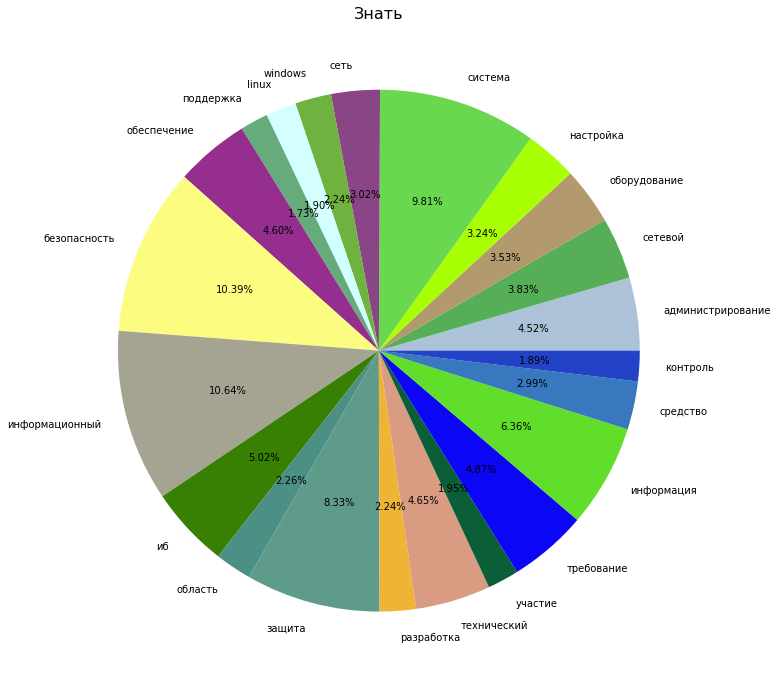

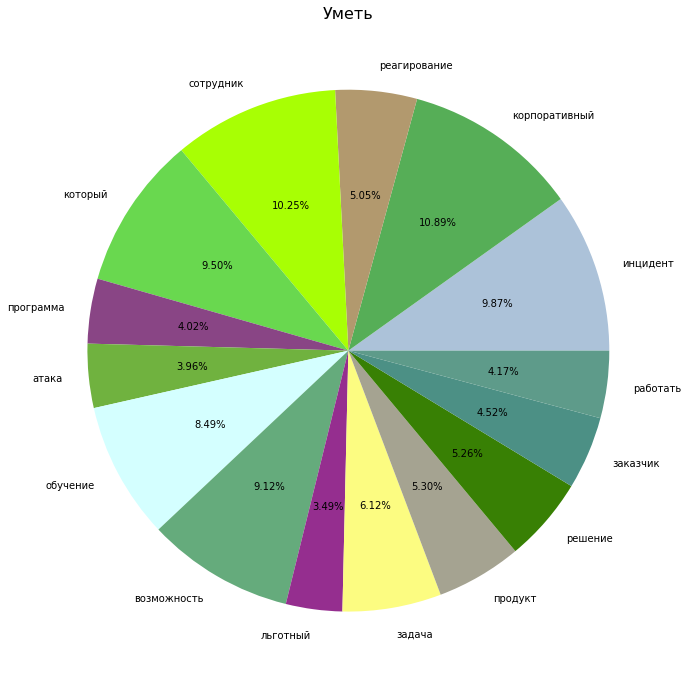

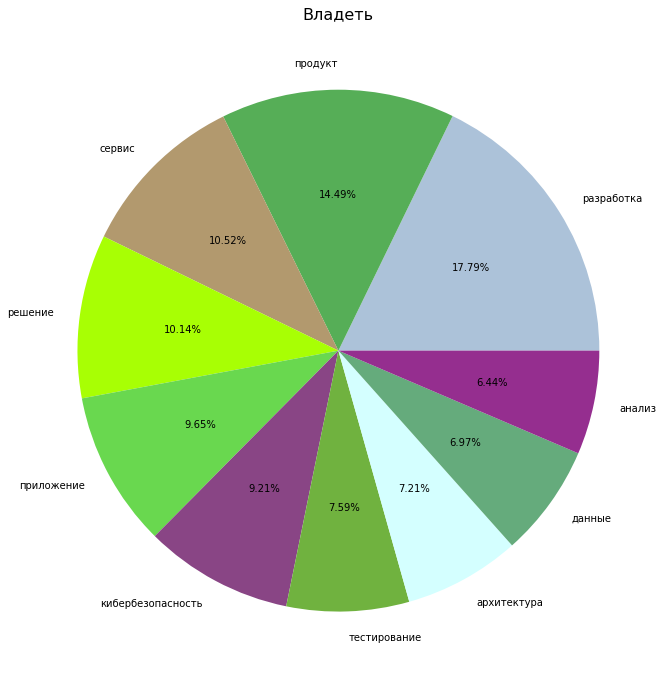

In [ ]:
for i in range(len(keys_descriptors)):
    theme_name = list(results_theme_profile.keys())[i]
    theme_terms = list(results_theme_profile[theme_name].keys())
    theme_weights = list(results_theme_profile[theme_name].values())
    draw_graph(theme_name, theme_terms, theme_weights, "pie")
